<a href="https://colab.research.google.com/github/sia-scaleup/colab_public/blob/main/12_kogaku_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google driveをマウント
# ローカル環境を使用する想定であれば、このセルは削除可です。
from google.colab import drive
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install -U numpy
!pip install matplotlib geopandas earthpy rasterio sentinelsat cartopy fiona shapely pyproj pygeos rtree rioxarray pystac-client sat-search rich --quiet

In [5]:
#必要ライブラリのインポート
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['figure.dpi'] = 300 # 解像度
import folium
import zipfile
import glob
import shutil
import cartopy
import fiona
import shapely
import pyproj
#import pygeos
import rtree
import cv2
import rasterio as rio
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon
from osgeo import gdal

import urllib
from satsearch import Search
from pystac_client import Client
from PIL import Image
import requests
import io
from pystac_client import Client
import warnings
warnings.filterwarnings('ignore')

print("done")

In [7]:
# 取得範囲を指定するための関数を定義
def selSquare(lon, lat, delta_lon, delta_lat):
    c1 = [lon + delta_lon, lat + delta_lat]
    c2 = [lon + delta_lon, lat - delta_lat]
    c3 = [lon - delta_lon, lat - delta_lat]
    c4 = [lon - delta_lon, lat + delta_lat]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

In [8]:
# 関心領域の緯度経度の情報取得．
from IPython.display import HTML
HTML(r'<iframe width="960" height="480" src="https://www.keene.edu/campus/maps/tool/" frameborder="0"></iframe>')

# NDVI解析で乾燥ストレス評価

In [10]:
# geeを使うためのインストール
!pip install -U earthengine-api geemap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.19
    Uninstalling earthengine-api-1.5.19:
      Successfully uninstalled earthengine-api-1.5.19


In [14]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

projectname = "ee-01-0524event"

# Earth Engineの認証
try:
    ee.Initialize(project=projectname)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=projectname)

In [30]:
# 対象エリアと期間の設定

region = ee.Geometry.Rectangle([137.2, 36.1, 137.6, 36.6])  # 例：東京都稲城市周辺
# 画像がありそうな期間（例：2023年11月〜2024年2月）
start_date = '2024-01-01'
end_date = '2024-02-29'

band = "VV" #SARデータ

# Sentinel-1 VV画像の収集
s2_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(region)
              .filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))
# 各画像の日付をリストで取得
dates = s2_col.aggregate_array('system:time_start').getInfo()

# 日付を読みやすく変換（ミリ秒→YYYY-MM-DD）
import datetime
date_list = [datetime.datetime.utcfromtimestamp(t / 1000).strftime('%Y-%m-%d') for t in dates]

# 表示
print(f" 利用可能日付（{start_date}〜{end_date}）:")
for d in sorted(date_list):
    print(d)



 利用可能日付（2024-01-01〜2024-02-29）:
2024-01-05
2024-01-05
2024-01-05
2024-01-30
2024-01-30
2024-01-30
2024-02-14
2024-02-14


In [31]:
# === Sentinel-2データの取得と前処理 ===
# Sentinel-2 コレクション取得（バンド付き画像のまま）

collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(region)
              .filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))

# 各画像にNDVIを追加
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

collection_with_ndvi = collection.map(add_ndvi)

# NDVIバンドの中央値合成画像を取得
ndvi = collection_with_ndvi.select('NDVI').median()



In [33]:
# 可視化設定
ndvi_vis = {
    'min': 0.0,
    'max': 1.0,
    'palette': ['blue', 'white', 'green'],
}

Map = geemap.Map(center=[36.14,137.58], zoom=10)
Map.addLayer(ndvi, ndvi_vis, 'NDVI')
Map.addLayer(region, {}, 'Area')
Map


Map(center=[36.14, 137.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

# NDVIの切り出しとヒストグラム表示

NDVI Image Preview URL: https://earthengine.googleapis.com/v1/projects/ee-01-0524event/thumbnails/86c036f896dbeab21cda3f9217ac7d70-08d442fbccb5507b56669611f9db81b2:getPixels


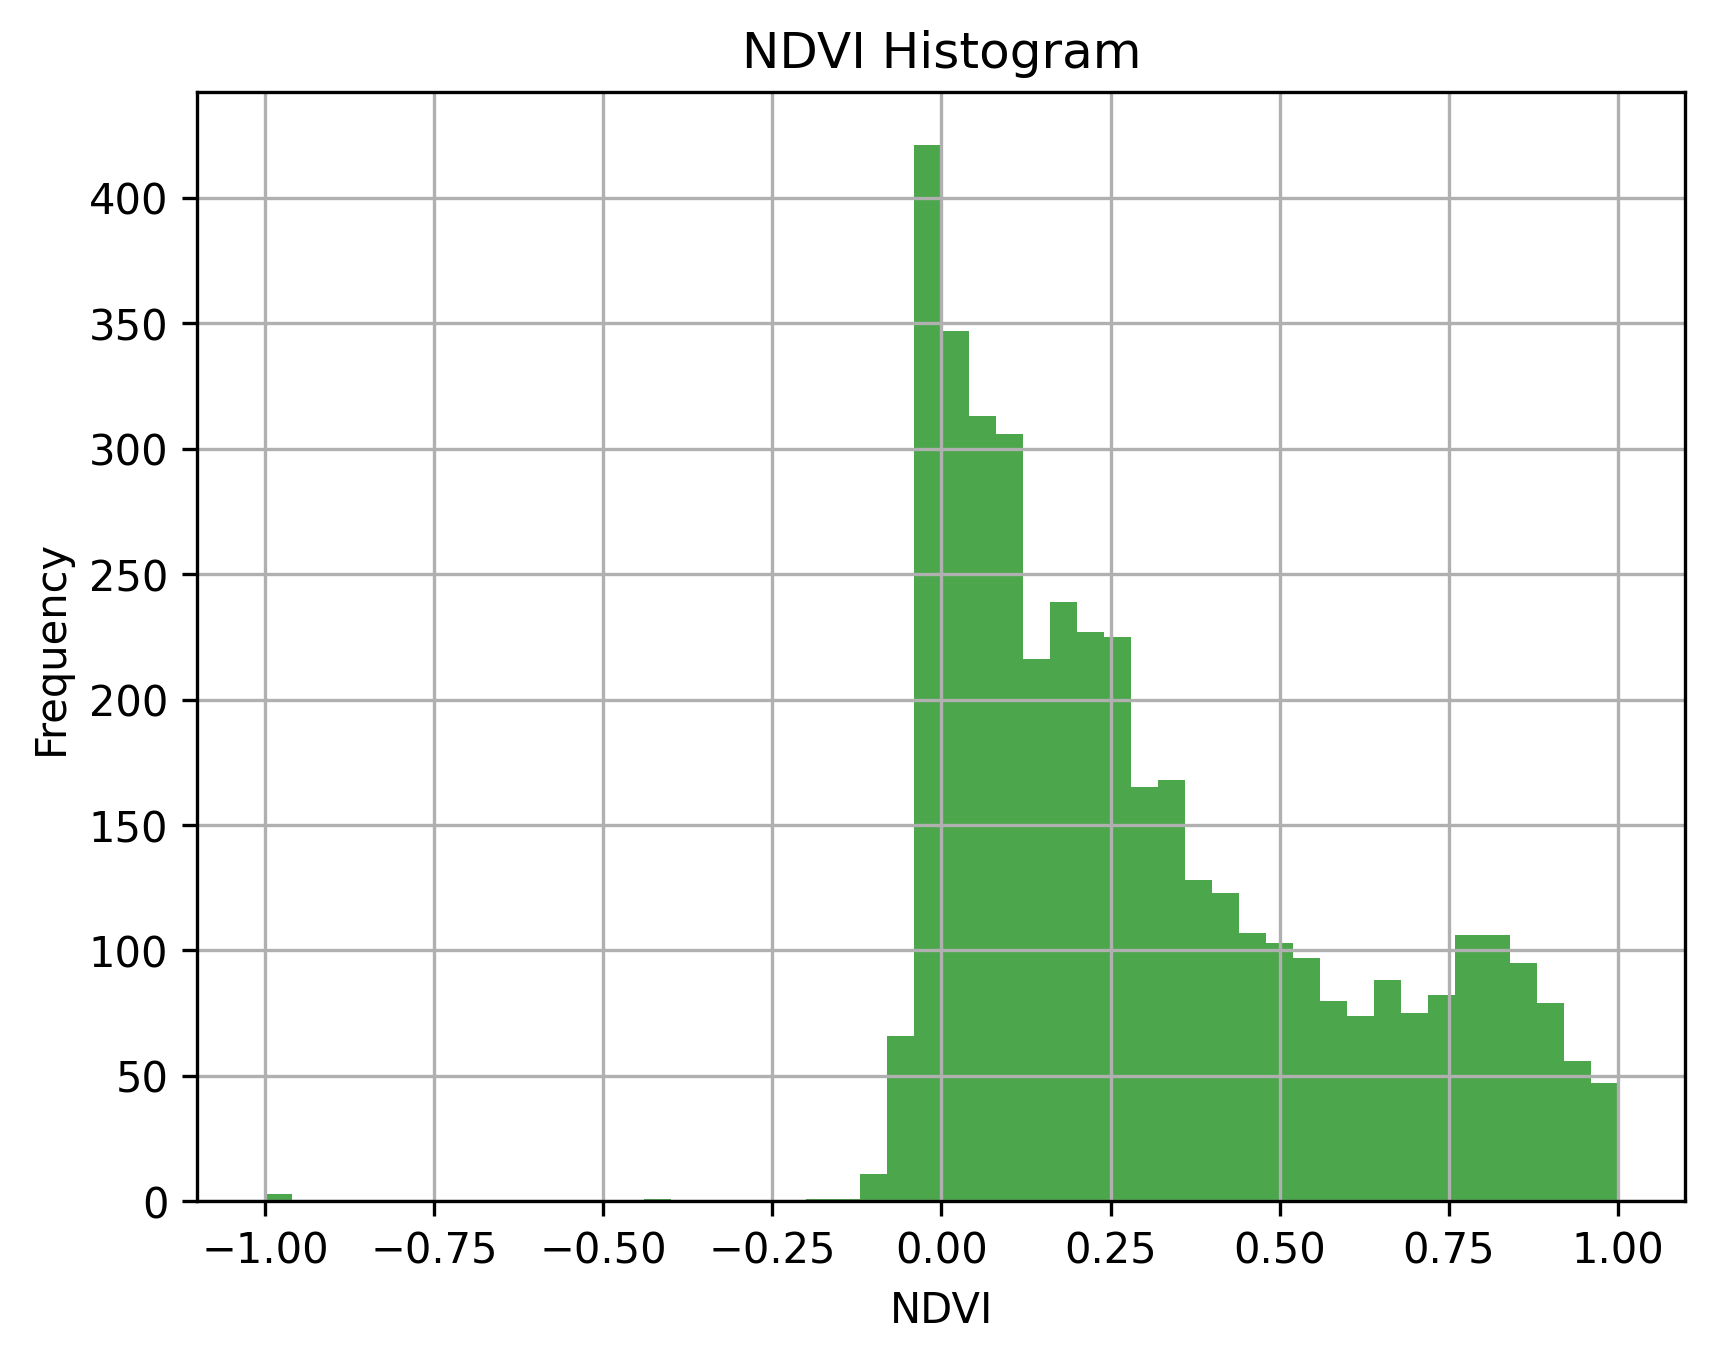

In [34]:
# NDVI画像からROIで切り出し（サンプリング）
ndvi_clipped = ndvi.clip(region)

# ピクセル値をサンプリングしてヒストグラム表示
url = ndvi_clipped.getThumbURL({
    'min': 0,
    'max': 1,
    'dimensions': 512,
    'region': region,
    'format': 'PNG'
})

print(f"NDVI Image Preview URL: {url}")

# サンプリングしてNDVI値をnumpyに変換
sample = ndvi_clipped.sample(region=region, scale=10, numPixels=5000)
ndvi_values = np.array(sample.aggregate_array('NDVI').getInfo())

# ヒストグラム表示
plt.hist(ndvi_values, bins=50, color='green', alpha=0.7)
plt.title("NDVI Histogram")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# 発展課題
- 他の月（例：2023年4月）のNDVIと比較し、変化を検出
- 閾値（例：NDVI < 0.4）でマスクし、乾燥ストレス領域の抽出
- 学習データとするためのラスターデータの正規化・保存（TFRecord or NumPy）